In [2]:
#Import all modules. Set path for iimporting dishpill_models

import sys
import os
import pathlib
import datetime
import numpy as np
import pandas as pd
import scipy
import scipy.stats as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pingouin as pg
pd.options.display.max_columns = 150
%matplotlib inline
sns.set()
pd.set_option('display.max_rows', 250)
sns.set_style("whitegrid")
from scipy.stats import ttest_ind
from statsmodels.stats.anova import AnovaRM
import warnings
warnings.filterwarnings('ignore')
path = "../models"
if not path in sys.path:
    sys.path.append(path)
%reload_ext autoreload
%autoreload 1
from statannot import add_stat_annotation
import math

import dishpill_models

In [3]:
#group_data takes a pandas data frame and a list of tags, and assigns: whether it is a control trials,
#    a rounded elapsed minute to each trial, and groups into two timepoints or "halfs". 
def group_data(dataframe, tag_list):
    print("Chosen tags are", tag_list)
    df = dataframe
    mask = df['tag'].isin(tag_list)
    df = df[mask]
    group = df['tag'].str.contains('ctl', case = False)
    df['group'] = group.astype(int)
    halfmask = df['elapse_seconds']>t1
    df['elapse_minute_rounded'] = np.int32(df['elapse_seconds'] / 60.)
    df.loc[:,'half'] = halfmask
    df["half"] = df["half"].astype(int)
    
    #df = df[df['hit_count']>0]
    df
    return df

In [4]:
#To determine whether an outlier exists in a given column of data

def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 4)
    upper_limit = s.mean() + (s.std() * 4)
    return ~s.between(lower_limit, upper_limit)

In [5]:
#use this to find unique ids generated by error as part of a false start.  

def find_unique_ids(ids):
    counts = {}
    for x in ids:
        # .get(x, 0) returns a default of 0 so you don't have to do if x in counts
        counts[x] = counts.get(x, 0) + 1
    return [key for key, value in counts.items() if value == 1]

In [6]:
# use to this calculate probability and ln probability of hit_counts and shape data per 
# group to plot as heatmap
def hmShape(hmdf, groupNum):
    hmdfmask = ((hmdf['group'] == groupNum) & (hmdf['elapse_minute_rounded'] != 20))
    maskedhmdf = hmdf[hmdfmask]
    
    #This parts generates counts of the number of hits in a minute and works this out in log odds format (decibals).
    hmName = maskedhmdf.groupby(['elapse_minute_rounded', 'hit_count']).agg({'count':'sum'})                                                                      
    hmName = hmName.unstack(level=0)
    hchmnamecopy= hmName[['count']].copy()
    hchmname = hchmnamecopy.fillna(0)
    hchmname =hchmname.sort_values(by='hit_count', ascending=False)
    hchmname = hchmname.replace(0, 1)
    hchmname = hchmname.div(hchmname.sum(axis=0), axis=1)
    hchmname = ((1/hchmname)-1)
    hchmname[hchmname.columns[0:20]] = 10*np.log10(hchmname[hchmname.columns[0:20]])
    hchmname = hchmname.replace('inf', 0)
    hchmname = hchmname.fillna(0)
    
    #generates array cdf of hit counts
    cdfdfmask = ((hmdf['group'] == groupNum) & (hmdf['elapse_minute_rounded'] != 20) & (hmdf['half'] == 1))
    maskedcdfhmdf = hmdf[cdfdfmask]
    cdfhc = maskedcdfhmdf.groupby(['hit_count']).agg({'count':'sum'}) 
    cdfhc = cdfhc/cdfhc.sum()
    cdfhc = np.cumsum(cdfhc)
    cdfhc = cdfhc.reset_index()
    
    
    return hchmname, cdfhc


In [7]:
df = pd.read_pickle('in_vitro_cells_sentience_1.pkl')


In [8]:
#Group into minutes and take the mean. Filter out data where errors in collection or cell
# activity have been noted. Typically this is when testing was done on chips that never displayed 
#suitable activity but we wanted to investigate to determine if a difference would arise or when a chip
#was faulty. Note that here most filtered (both rest and active sessions) are from a single tag where
#cells never displayed any robust activity. in-silico sessions removed are 1) due to faulty record and 
#2) due to the wrong tag being put in on one nuc so it was testingg something else. 


df2 = df.groupby(['group', 'tag', 'chip_id', 'date', 'session_num', 'half', 'elapse_minute_rounded', 'elapse_seconds', 'number']).sum()

df2 = df2.drop(index = (0, 'prim_test_rate_code_random_3', '9381'))
df2 = df2.drop(index = (3, 'prim_test_rate_code_random_3', '9381'))
df2 = df2.drop(index = (1, 'ctl_test_rate_code_3', '8127'))
df2 = df2.drop(index = (1, 'ctl_test_reseed', '8127'))
df2 = df2.drop(index = (1, 'ctl_test_reseed', '9751'))
df2 = df2.drop(index = (1, 'ctl_test_reseed', '8137', '2021-06-19'))
df2 = df2.drop(index = (4, 'in-silico_ratecode_spikes_reseed', '003', '2021-06-11', 1.0))
df2 = df2.drop(index = (4, 'in-silico_ratecode_spikes_reseed', '003', '2021-06-22'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '11618'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '11618'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '11623'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '11623'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '11597'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '11597'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '11613'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '11613'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '9358', '2021-06-18'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '11615', '2021-06-21'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '9495', '2021-06-02'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '9495', '2021-06-07'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '9495', '2021-06-18'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '9353', '2021-06-02'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '9358', '2021-06-18'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '11615', '2021-06-21'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '9495', '2021-06-02'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '9495', '2021-06-07'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '9495', '2021-06-18'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '9353', '2021-06-02'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '9468'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '9468'))

In [9]:
temp = df2.reset_index()
hmdf = temp[['group', 'elapse_minute_rounded', 'half', 'hit_count', 'count', 'ace', 'long_rally']].copy()
hmdf['hit_count'] = np.where(hmdf['hit_count'] > 4, 5, hmdf['hit_count'])
hmdf

group  elapse_minute_rounded  half  hit_count  count  ace  long_rally
0          0                      0     0        2.0      1    0           0
1          0                      0     0        0.0      1    1           0
2          0                      0     0        0.0      1    1           0
3          0                      0     0        1.0      1    0           0
4          0                      1     0        0.0      1    1           0
...      ...                    ...   ...        ...    ...  ...         ...
34041      4                     19     1        0.0      1    1           0
34042      4                     19     1        0.0      1    1           0
34043      4                     19     1        0.0      1    1           0
34044      4                     19     1        0.0      1    1           0
34045      4                     19     1        0.0      1    1           0

[34046 rows x 7 columns]

In [10]:
hcprimhmdf, cdfprim = hmShape(hmdf, 0)
hcctlhmdf, cdfctl = hmShape(hmdf, 1)
hchcchmdf, cdfhcc = hmShape(hmdf, 2)
hcrsthmdf, cdfrst = hmShape(hmdf, 3)
hcishmdf, cdfis = hmShape(hmdf, 4)
hcctlhmdf

count                                              \
elapse_minute_rounded         0          1          2          3          4    
hit_count                                                                      
5.0                    24.548449  21.507564  19.700368  16.532125  18.356906   
4.0                    14.882373  19.731279  14.835081  21.367206  14.281348   
3.0                    11.728623  14.393327  13.174204  15.846542  17.371926   
2.0                     7.288045  12.256323   8.093825   8.101962   7.619645   
1.0                     2.896901   4.011451   5.430821   4.522977   5.981649   
0.0                     1.659909  -1.888281  -0.955291  -0.884219  -1.450570   

                                                                              \
elapse_minute_rounded         5          6          7          8          9    
hit_count                                                                      
5.0                    16.548180  17.403627  21.789769  21.383027  19.807606   
4.0                    18.341027  14.787268  20.014452  19.606293  19.807606   
3.0                    12.738277  13.489535  15.682017  13.834890  14.042115   
2.0                    10.034605  10.691970  11.078264   8.995734   8.349188   
1.0                     3.990381   3.679768   4.620138   5.310732   4.266554   
0.0                    -0.659763  -0.496878  -2.279549  -1.813238  -0.720480   

                                                                              \
elapse_minute_rounded         10         11         12         13         14   
hit_count                                                                      
5.0                    17.558749  19.164539  19.542425  19.370161  22.253093   
4.0                    19.344985  15.105450  22.576786  17.584072  19.216865   
3.0                    11.707949  12.983071  16.483600  15.314789  17.429868   
2.0                    10.928825   9.179138   9.334340  10.280287   9.513947   
1.0                     4.067139   4.331473   6.876153   5.006024   4.271473   
0.0                    -0.901766  -0.572954  -3.410352  -2.073490  -1.611509   

                                                                              
elapse_minute_rounded         15         16         17         18         19  
hit_count                                                                     
5.0                    13.452337  17.047223  12.872417  15.078559  16.101276  
4.0                    17.242759  21.875207  15.993371  19.138139  16.101276  
3.0                    12.844307  11.169698  14.996871  12.416571  16.101276  
2.0                     7.812870   7.814290   9.060955  11.083395  10.385634  
1.0                     4.842998   4.018703   4.320943   4.983106   4.875867  
0.0                     0.000000   0.392533  -0.266522  -1.587172  -1.739252

In [11]:
flat_prim = hcprimhmdf.stack()
flat_rest = hcishmdf.stack()
flat_hcc = hchcchmdf.stack()
flat_ctl = hcctlhmdf.stack()
flat_is = hcishmdf.stack()

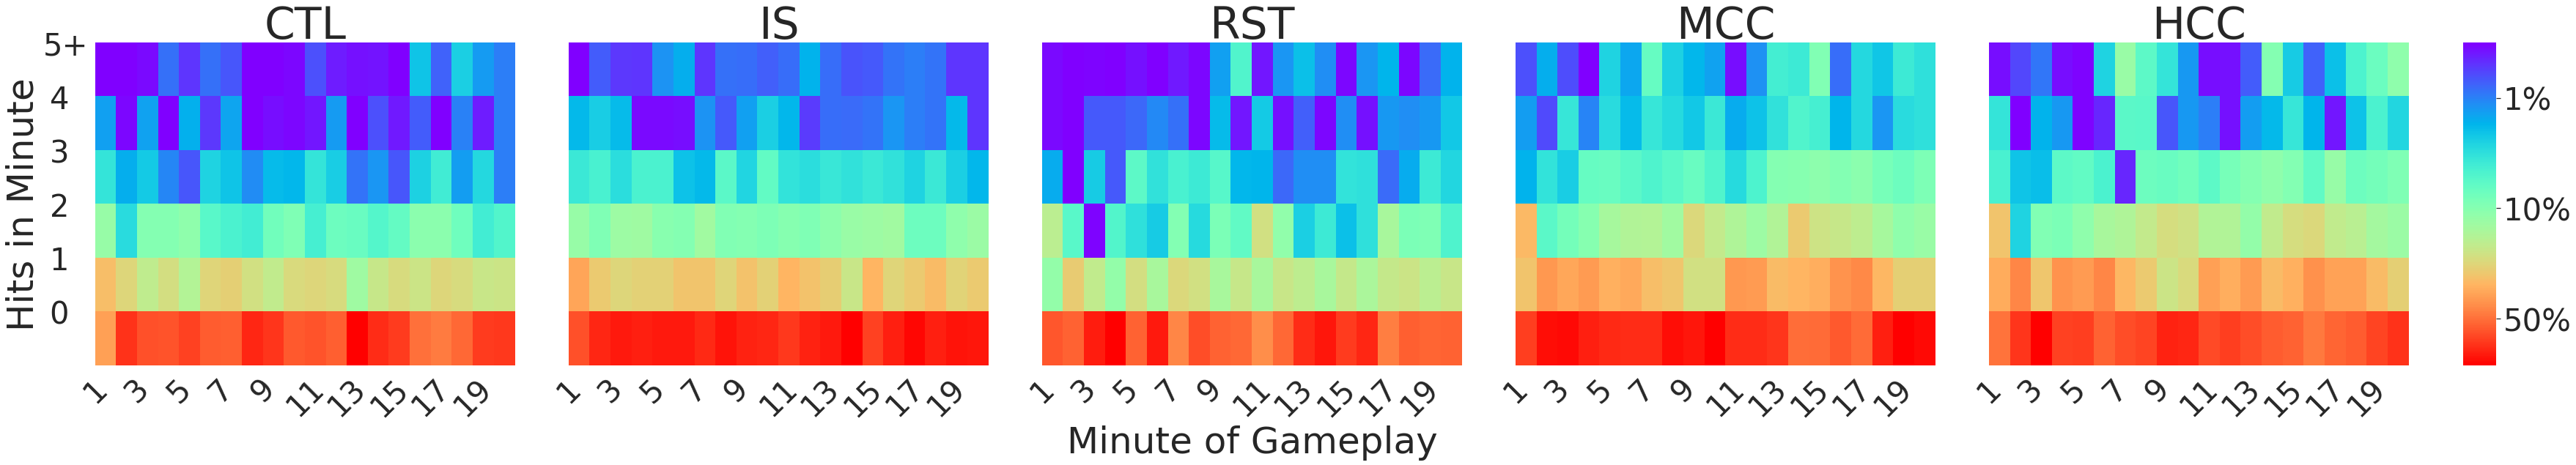

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(font_scale = 3.8)
fig, (ax1,ax2,ax3,ax4,ax5, axcb) = plt.subplots(1, 6, figsize=(50, 10), 
                                                gridspec_kw={'width_ratios':[1,1,1,1,1,0.08]})

fig.subplots_adjust(wspace=0.1)
sns.heatmap(hcctlhmdf, ax=ax1, cmap='rainbow_r',cbar_ax=axcb, vmax =20)
sns.heatmap(hcishmdf, ax=ax2, cmap='rainbow_r', cbar=False, yticklabels=False)
sns.heatmap(hcrsthmdf, ax=ax3, cmap='rainbow_r',cbar=False, yticklabels=False)
sns.heatmap(hcprimhmdf, ax=ax4, cmap='rainbow_r', cbar=False, yticklabels=False)
sns.heatmap(hchcchmdf, ax=ax5, cmap='rainbow_r', cbar=False,  yticklabels=False)
axcb.set_yticklabels([' ', '50%', '10%', '1%'])
axcb.yaxis.set_major_locator(plt.MaxNLocator(3))
num = list(range(1,21, 2))
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax2.xaxis.set_major_locator(plt.MaxNLocator(10))
ax3.xaxis.set_major_locator(plt.MaxNLocator(10))
ax4.xaxis.set_major_locator(plt.MaxNLocator(10))
ax5.xaxis.set_major_locator(plt.MaxNLocator(10))

ax1.set_xticklabels(num, rotation=45)
ax2.set_xticklabels(num, rotation=45)
ax3.set_xticklabels(num, rotation=45)
ax4.set_xticklabels(num, rotation=45)
ax5.set_xticklabels(num, rotation=45)
ax1.yaxis.set_major_locator(plt.MaxNLocator(6))
ax1.set_yticklabels(['5+','4  ', '3  ', '2  ', '1  ', '0  '], rotation = 360)
ax2.set(ylabel=None)
ax3.set(ylabel=None)
ax4.set(ylabel=None)
ax5.set(ylabel=None)

ax1.set(xlabel=None)
ax2.set(xlabel=None)
ax3.set_xlabel("Minute of Gameplay", size = 50)
ax1.set_ylabel("Hits in Minute", size = 50)
ax4.set(xlabel=None)
ax5.set(xlabel=None)

ax4.set_title("MCC", size = 60)
ax5.set_title("HCC", size = 60)
ax1.set_title("CTL", size = 60)
ax2.set_title("IS", size = 60)
ax3.set_title("RST", size = 60)
plt.tight_layout()
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/heatmap_main.pdf')
plt.show()


In [16]:
num = list(range(1,21, 2))
print(num)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]


In [17]:
#Group into minutes and take the mean. Filter out data where errors in collection or cell
# activity have been noted. Typically this is when testing was done on chips that never displayed 
#suitable activity but we wanted to investigate for a different reason or when a chip
#was faulty. Note that here most filtered (both rest and active sessions) are from a single tag where
#cells never displayed any robust activity. in-silico sessions removed are 1) due to faulty record and 
#2) due to the wrong tag being put in on one nuc so it was testing something else. 


df2 = df.groupby(['group', 'tag', 'chip_id', 'date', 'session_num', 'half', 'elapse_minute_rounded']).mean()

df2 = df2.drop(index = (0, 'prim_test_rate_code_random_3', '9381'))
df2 = df2.drop(index = (3, 'prim_test_rate_code_random_3', '9381'))
df2 = df2.drop(index = (1, 'ctl_test_rate_code_3', '8127'))
df2 = df2.drop(index = (1, 'ctl_test_reseed', '8127'))
df2 = df2.drop(index = (1, 'ctl_test_reseed', '9751'))
df2 = df2.drop(index = (1, 'ctl_test_reseed', '8137', '2021-06-19'))
df2 = df2.drop(index = (4, 'in-silico_ratecode_spikes_reseed', '003', '2021-06-11', 1.0))
df2 = df2.drop(index = (4, 'in-silico_ratecode_spikes_reseed', '003', '2021-06-22'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '11618'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '11618'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '11623'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '11623'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '11597'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '11597'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '11613'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '11613'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '9358', '2021-06-18'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '11615', '2021-06-21'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '9495', '2021-06-02'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '9495', '2021-06-07'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '9495', '2021-06-18'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '9353', '2021-06-02'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '9358', '2021-06-18'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '11615', '2021-06-21'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '9495', '2021-06-02'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '9495', '2021-06-07'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '9495', '2021-06-18'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '9353', '2021-06-02'))
df2 = df2.drop(index = (2, 'GFP_low_test_rate_code_random_3', '9468'))
df2 = df2.drop(index = (3, 'GFP_low_test_rate_code_random_3', '9468'))

In [18]:
#to analyse by timepoint we then reset the index and group it by the half we defined earlier. 

df4 = df2.reset_index()
df5 = df4.groupby(['group', 'tag', 'chip_id', 'date', 'session_num', 'half']).mean()

# We then reset the index again to get a single index dataframe and assign a unique id to each chip
df4 = df5.reset_index()
df4["id"] = ((df4['chip_id']).astype(str)) + ((df4['date']).astype(str)) +((df4['session_num']).astype(str))

#Create a string name for each group for easier access

df4['group_name'] = 99
df4['group_name'] = np.where((df4['group']== 0), "MCC", df4['group_name'])
df4['group_name'] = np.where((df4['group']== 1), "CTL", df4['group_name'])
df4['group_name'] = np.where((df4['group']== 2), "HCC", df4['group_name'])
df4['group_name'] = np.where((df4['group']== 3), "RST", df4['group_name'])
df4['group_name'] = np.where((df4['group']== 4), "IS", df4['group_name'])

group                              tag chip_id       date  session_num  \
250      1             ctl_test_rate_code_3    9751 2021-04-28          4.0   
251      1             ctl_test_rate_code_3    9751 2021-04-28          4.0   
252      1                  ctl_test_reseed    6542 2021-06-18          0.0   
253      1                  ctl_test_reseed    6542 2021-06-18          0.0   
254      1                  ctl_test_reseed    6542 2021-06-18          1.0   
255      1                  ctl_test_reseed    6542 2021-06-18          1.0   
256      1                  ctl_test_reseed    6542 2021-06-18          2.0   
257      1                  ctl_test_reseed    6542 2021-06-18          2.0   
258      1                  ctl_test_reseed    6542 2021-06-18          3.0   
259      1                  ctl_test_reseed    6542 2021-06-18          3.0   
260      1                  ctl_test_reseed    6542 2021-06-18          4.0   
261      1                  ctl_test_reseed    6542 2021-06-18          4.0   
262      1                  ctl_test_reseed    6542 2021-06-19          0.0   
263      1                  ctl_test_reseed    6542 2021-06-19          0.0   
264      1                  ctl_test_reseed    6542 2021-06-19          1.0   
265      1                  ctl_test_reseed    6542 2021-06-19          1.0   
266      1                  ctl_test_reseed    6542 2021-06-19          2.0   
267      1                  ctl_test_reseed    6542 2021-06-19          2.0   
268      1                  ctl_test_reseed    6542 2021-06-19          3.0   
269      1                  ctl_test_reseed    6542 2021-06-19          3.0   
270      1                  ctl_test_reseed    6542 2021-06-19          4.0   
271      1                  ctl_test_reseed    6542 2021-06-19          4.0   
272      1                  ctl_test_reseed    7963 2021-06-18          2.0   
273      1                  ctl_test_reseed    7963 2021-06-18          2.0   
274      1                  ctl_test_reseed    7963 2021-06-18          3.0   
275      1                  ctl_test_reseed    7963 2021-06-18          3.0   
276      1                  ctl_test_reseed    7963 2021-06-18          4.0   
277      1                  ctl_test_reseed    7963 2021-06-18          4.0   
278      1                  ctl_test_reseed    7963 2021-06-18          5.0   
279      1                  ctl_test_reseed    7963 2021-06-18          5.0   
280      1                  ctl_test_reseed    7963 2021-06-18          6.0   
281      1                  ctl_test_reseed    7963 2021-06-18          6.0   
282      1                  ctl_test_reseed    7963 2021-06-19          0.0   
283      1                  ctl_test_reseed    7963 2021-06-19          0.0   
284      1                  ctl_test_reseed    7963 2021-06-19          1.0   
285      1                  ctl_test_reseed    7963 2021-06-19          1.0   
286      1                  ctl_test_reseed    7963 2021-06-19          2.0   
287      1                  ctl_test_reseed    7963 2021-06-19          2.0   
288      1                  ctl_test_reseed    7963 2021-06-19          3.0   
289      1                  ctl_test_reseed    7963 2021-06-19          3.0   
290      1                  ctl_test_reseed    7963 2021-06-19          4.0   
291      1                  ctl_test_reseed    7963 2021-06-19          4.0   
292      1                  ctl_test_reseed    7963 2021-06-20          0.0   
293      1                  ctl_test_reseed    7963 2021-06-20          0.0   
294      1                  ctl_test_reseed    7963 2021-06-20          1.0   
295      1                  ctl_test_reseed    7963 2021-06-20          1.0   
296      1                  ctl_test_reseed    7963 2021-06-20          2.0   
297      1                  ctl_test_reseed    7963 2021-06-20          2.0   
298      1                  ctl_test_reseed    7963 2021-06-20          3.0   
299      1                  ctl_test_reseed    7963 202

In [20]:
#check for false starts that have no input in second half. 
false_starts = find_unique_ids(df4['id'])
for x in false_starts:
    df4 = df4[df4.id != x]
    

In [34]:
#group all the control groups and group the active experimental groups, perform t-test. 
df3 = df4.groupby(['group', 'tag', 'chip_id', 'date', 'session_num', 'half']).mean()
control = df3.drop(index = (0,))
control = control.drop(index = (2,))
exp = df3.drop(index = (1,))
exp = exp.drop(index = (3,))
exp = exp.drop(index = (4,))

hc_t = stats.ttest_ind(control['hit_count'], exp['hit_count'])
ace_t = stats.ttest_ind(control['ace'], exp['ace'])
lr_t = stats.ttest_ind(control['long_rally'], exp['long_rally'])

#Group by treatment and half for each treatment. 

control0 = df4[(df4.half == 0) & (df4.group == 1)]  
control1 = df4[(df4.half == 1) & (df4.group == 1)]  

prim0 = df4[(df4.half == 0) & (df4.group == 0)]  
prim1 = df4[(df4.half == 1) & (df4.group == 0)]  

hCC0 = df4[(df4.half == 0) & (df4.group == 2)]  
hCC1 = df4[(df4.half == 1) & (df4.group == 2)]  

rest0 = df4[(df4.half == 0) & (df4.group == 3)]  
rest1 = df4[(df4.half == 1) & (df4.group == 3)] 

insil0 = df4[(df4.half == 0) & (df4.group == 4)]  
insil1 = df4[(df4.half == 1) & (df4.group == 4)]  


#repeated measures t-tests for each group

ctl_lr= stats.ttest_rel(control0['long_rally'], control1['long_rally'])
ctl_ace = stats.ttest_rel(control0['ace'], control1['ace'])
ctl_hc = stats.ttest_rel(control0['hit_count'], control1['hit_count'])

prim_lr = stats.ttest_rel(prim0['long_rally'], prim1['long_rally'])
prim_ace = stats.ttest_rel(prim0['ace'], prim1['ace'])
prim_hc = stats.ttest_rel(prim0['hit_count'], prim1['hit_count'])

hCC_lr = stats.ttest_rel(hCC0['long_rally'], hCC1['long_rally'])
hCC_ace = stats.ttest_rel(hCC0['ace'], hCC1['ace'])
hCC_hc = stats.ttest_rel(hCC0['hit_count'], hCC1['hit_count'])

rest_lr = stats.ttest_rel(rest0['long_rally'], rest1['long_rally'])
rest_ace = stats.ttest_rel(rest0['ace'], rest1['ace'])
rest_hc = stats.ttest_rel(rest0['hit_count'], rest1['hit_count'])

insil_lr = stats.ttest_rel(insil0['long_rally'], insil1['long_rally'])
insil_ace = stats.ttest_rel(insil0['ace'], insil1['ace'])
insil_hc = stats.ttest_rel(insil0['hit_count'], insil1['hit_count'])


In [22]:
#do mixed anovas for long rallies, aces and hit count. 

rmanova_lr = pg.mixed_anova(data=df4, dv=('long_rally'), subject=('id'), between='group', within='half', correction = False)
rmanova_ace = pg.mixed_anova(data=df4, dv=('ace'), subject=('id'), between='group', within='half', correction = False)
rmanova_hc = pg.mixed_anova(data=df4, dv=('hit_count'), subject=('id'), between='group', within='half', correction = False)

#split timepoints into first and last timepoints

first = df4[(df4.half == 0)]  
last = df4[(df4.half == 1)]  

#follow up the significant interactions between all rm anovas. 

first_anova_lr = pg.anova(data=first, dv=('long_rally'), between='group', detailed = True)
first_anova_ace = pg.anova(data=first, dv=('ace'), between='group', detailed = True)
first_anova_hc = pg.anova(data=first, dv=('hit_count'), between='group', detailed = True)

last_anova_lr = pg.anova(data=last, dv=('long_rally'), between='group', detailed = True)
last_anova_ace = pg.anova(data=last, dv=('ace'), between='group', detailed = True)
last_anova_hc = pg.anova(data=last, dv=('hit_count'), between='group', detailed = True)

#post hoc tests to figure out what is going in where anova are significant. 
first_ph_lr = pg.pairwise_gameshowell(data =first, dv='long_rally', between='group_name').round(3)
first_ph_ace = pg.pairwise_gameshowell(data =first, dv='ace', between='group_name').round(3)
first_ph_hc = pg.pairwise_gameshowell(data =first, dv='hit_count', between='group_name').round(3)

last_ph_lr = pg.pairwise_gameshowell(data =last, dv='long_rally', between='group_name').round(3)
last_ph_ace = pg.pairwise_gameshowell(data =last, dv='ace', between='group_name').round(3)
last_ph_hc = pg.pairwise_gameshowell(data =last, dv='hit_count', between='group_name').round(3)

In [23]:
#Print results for all t-tests both independent and related. 

print("df for exp vs ctl = ", len(control) + len(exp)-1)

print("t-test for control hit count vs experimental hit count = ", hc_t)
print("t-test for control aces vs experimental aces = ", ace_t)
print("t-test for control long rally vs experimental long rally = ", lr_t)

print("df for rm ctl = ", len(control0)-1)
print("rm t-test media control long rallies  = ", ctl_lr)
print("rm t-test media control aces  = ", ctl_ace)
print("rm t-test media control hit counts = ", ctl_hc)

print("df for rm in silico = ", len(insil0)-1)
print("rm t-test media in silico long rallies  = ", insil_lr)
print("rm t-test media in silico aces  = ", insil_ace)
print("rm t-test media in silico hit counts = ", insil_hc)


print("df for rm rest = ", len(rest1)-1)
print("rm t-test media rest long rallies  = ", rest_lr)
print("rm t-test media rest aces  = ", rest_ace)
print("rm t-test media rest hit counts = ", rest_hc)

print("df for rm primary = ", len(prim1)-1)
print("rm t-test media primary long rallies  = ", prim_lr)
print("rm t-test media primary aces  = ", prim_ace)
print("rm t-test media primary hit counts = ", prim_hc)


print("df for rm hcc = ", len(hCC0)-1)
print("rm t-test media hCC long rallies  = ", hCC_lr)
print("rm t-test media hCC aces  = ", hCC_ace)
print("rm t-test media hCC hit counts = ", hCC_hc)


df for exp vs ctl =  797
t-test for control hit count vs experimental hit count =  Ttest_indResult(statistic=-2.3157778156398465, pvalue=0.02082369124926077)
t-test for control aces vs experimental aces =  Ttest_indResult(statistic=3.80474009773795, pvalue=0.0001528316721006869)
t-test for control long rally vs experimental long rally =  Ttest_indResult(statistic=1.520998005950367, pvalue=0.12865745226534625)
df for rm ctl =  79
rm t-test media control long rallies  =  Ttest_relResult(statistic=0.16950569618890124, pvalue=0.8658321916702031)
rm t-test media control aces  =  Ttest_relResult(statistic=-1.3385046410767407, pvalue=0.18457144615154902)
rm t-test media control hit counts =  Ttest_relResult(statistic=0.5395416536140155, pvalue=0.5910306856016185)
df for rm in silico =  37
rm t-test media in silico long rallies  =  Ttest_relResult(statistic=0.9944638071151916, pvalue=0.3264565825548438)
rm t-test media in silico aces  =  Ttest_relResult(statistic=-1.4289488684020248, pvalue=0.

In [24]:
#print all anova and follow up testing results. 
print("rm anova long rallies")
pg.print_table(rmanova_lr)
print("anova long rallies first timepoint")
pg.print_table(first_anova_lr)
print("post hoc test long rallies first timepoint")
print(first_ph_lr)
print("anova long rallies second timepoint")
pg.print_table(last_anova_lr)
print("post hoc test long rallies last timepoint")
print(last_ph_lr)


print("rm anova aces")
pg.print_table(rmanova_ace)
print("anova aces first timepoint")
pg.print_table(first_anova_ace)
print("post hoc test aces first timepoint")
print(first_ph_ace)
print("anova aces second timepoint")
pg.print_table(last_anova_ace)
print("post hoc test aces last timepoint")
print(last_ph_ace)


print("rm anova hit counts")
pg.print_table(rmanova_hc)
print("anova hit count first timepoint")
pg.print_table(first_anova_hc)
print("post hoc test hit count first timepoint")
print(first_ph_hc)
print("anova hit count second timepoint")
pg.print_table(last_anova_hc)
print("post hoc test hit count last timepoint")
print(last_ph_hc)



rm anova long rallies

ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
group        0.069      4    394  0.017   4.767    0.001  0.046  nan
half         0.206      1    394  0.206  59.746    0.000  0.132    1.000
Interaction  0.186      4    394  0.047  13.531    0.000  0.121  nan

anova long rallies first timepoint

ANOVA SUMMARY

Source       SS    DF     MS        F    p-unc      np2
--------  -----  ----  -----  -------  -------  -------
group     0.186     4  0.046   10.191    0.000    0.094
Within    1.797   394  0.005  nan      nan      nan

post hoc test long rallies first timepoint
     A    B  mean(A)  mean(B)   diff     se      T       df   pval  hedges
0  CTL  HCC    0.095    0.044  0.051  0.011  4.598  117.248  0.001   0.644
1  CTL   IS    0.095    0.093  0.002  0.013  0.136  107.875  0.900   0.027
2  CTL  MCC    0.095    0.073  0.022  0.012  1.791  148.918  0.3

In [25]:
#get mean and sem for all data and print. 
descriptives = df4.groupby(['group_name', 'half']).agg({('hit_count'): ['mean', sp.sem], 
                                                   ('long_rally'): ['mean', sp.sem],
                                                  ('ace'): ['mean', sp.sem]})
descriptives

hit_count           long_rally                 ace          
                     mean       sem       mean       sem      mean       sem
group_name half                                                             
CTL        0     0.899917  0.041105   0.095083  0.010006  0.508167  0.012997
           1     0.872139  0.031251   0.093021  0.007319  0.530138  0.010651
HCC        0     0.673559  0.028747   0.043889  0.004881  0.544867  0.008489
           1     1.128592  0.030007   0.106443  0.003650  0.482441  0.005653
IS         0     0.832026  0.032372   0.093252  0.008994  0.534891  0.013245
           1     0.801467  0.019153   0.083457  0.003883  0.555545  0.006723
MCC        0     0.780033  0.029887   0.073102  0.007110  0.533820  0.010759
           1     1.019606  0.025312   0.121776  0.005190  0.499003  0.007721
RST        0     0.765040  0.036573   0.092183  0.007197  0.585437  0.013183
           1     0.815317  0.038029   0.087460  0.007936  0.570397  0.015431

In [26]:
#sort by group to make plotting easier

df4['pltgroup'] = 99
df4['pltgroup'] = np.where((df4['group']== 0), "3", df4['pltgroup'])
df4['pltgroup'] = np.where((df4['group']== 1), "0", df4['pltgroup'])
df4['pltgroup'] = np.where((df4['group']== 2), "4", df4['pltgroup'])
df4['pltgroup'] = np.where((df4['group']== 3), "2", df4['pltgroup'])
df4['pltgroup'] = np.where((df4['group']== 4), "1", df4['pltgroup'])
df4 = df4.sort_values(by=['pltgroup'])

In [27]:
df4['%long_rally'] = df4['long_rally']*100
df4['%ace'] = df4['ace']*100

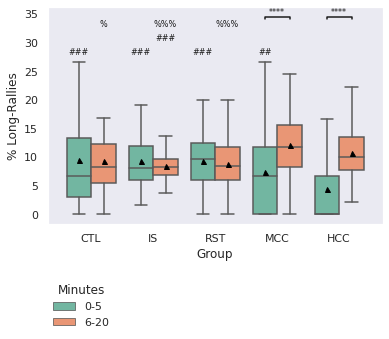

In [28]:
#box plot for long rallies

labels = df4.group_name.unique()
x_pos = np.arange(len(labels))
x = df4['group_name']
y = df4['%long_rally']
hue = df4['half']
sns.set(style="darkgrid")
ax = sns.boxplot(data=df, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title('Pong Performance over Time With All Features')
ax.set_ylabel('% Long-Rallies')
ax.set_xlabel('Group')
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='lower left', bbox_to_anchor=(0, -0.5), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')
#ax.set_ylim([0, 2.5])
y, h, col = 30, 0.5, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
x30, x31 = 2.8, 3.2
x40, x41 = 3.8, 4.2
#Plot t-test between groups
plt.plot([x30, x30, x31, x31], [y+4, y+h+4, y+h+4, y+4], lw=1.5, c=col)
plt.text(((x30 + x31)/2), y+ h+4, "****", ha='center', va='bottom', color=col,fontsize=8)
plt.plot([x40, x40, x41, x41], [y+4, y+h+4, y+h+4, y+4], lw=1.5, c=col)
plt.text(((x40 + x41)/2), y+ h+4, "****", ha='center', va='bottom', color=col,fontsize=8)
#Plot differences between groups time 2


plt.text(x00, y-2.5, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x10, y-2.5, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x20, y-2.5, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x30, y-2.5, "##", ha='center', va='bottom', color=col,fontsize=8)

plt.text(x11, y, "###", ha='center', va='bottom', color=col,fontsize=8)

plt.text(x01, y+2.5, "%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x11, y+2.5, "%%%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x21, y+2.5, "%%%", ha='center', va='bottom', color=col,fontsize=8)

#ax.set_ylim([-2, 40])
sns.set(rc={'figure.figsize':(3,3)})
# #= HCC
# % = MCC
#^ = CTL
# @ = Rest
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/long-rallies_with_sig.pdf', bbox_inches='tight')

In [29]:
#box plot for aces

labels = df4.group_name.unique()
x_pos = np.arange(len(labels))
x = df4['group_name']
y = df4['%ace']
hue = df4['half']
sns.set(style="darkgrid")
ax = sns.boxplot(data=df, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title('Pong Performance over Time With All Features')
ax.set_ylabel('% Aces')
ax.set_xlabel('Group')
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='lower left', bbox_to_anchor=(0, -0.5), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')
#ax.set_ylim([0, 2.5])
y, h, col = 20, -1.5, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
x30, x31 = 2.8, 3.2
x40, x41 = 3.8, 4.2
#Plot t-test between groups
plt.plot([x30, x30, x31, x31], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x30 + x31)/2), y-8, "****", ha='center', va='bottom', color=col,fontsize=8)
plt.plot([x40, x40, x41, x41], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x40 + x41)/2), y-8, "****", ha='center', va='bottom', color=col,fontsize=8)
#Plot differences between groups time 2
plt.text(x20, y+5, "%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x20, y-2, "^^^", ha='center', va='bottom', color=col,fontsize=8)

plt.text(x21, y-15, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x11, y-15, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x01, y-15, "###", ha='center', va='bottom', color=col,fontsize=8)

plt.text(x21, y-10, "%%%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x11, y-10, "%%%", ha='center', va='bottom', color=col,fontsize=8)


ax.set_ylim([-2, 80])
sns.set(rc={'figure.figsize':(3,3)})
# #= HCC
# % = MCC
#^ = CTL
# @ = IS
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/aces_with_sig.pdf', bbox_inches='tight') 

In [30]:
#box plot for hit counts

labels = df4.group_name.unique()
x_pos = np.arange(len(labels))
x = df4['group_name']
y = df4['hit_count']
hue = df4['half']
sns.set(style="darkgrid")
ax = sns.boxplot(data=df, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title('Pong Performance over \n Time With All Features')
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Group')
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='lower left', bbox_to_anchor=(0, -0.5), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')
y, h, col = 1.85, 0.02, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
x30, x31 = 2.8, 3.2
x40, x41 = 3.8, 4.2
#Plot t-test between groups
plt.plot([x30, x30, x31, x31], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x30 + x31)/2), y+ h, "****", ha='center', va='bottom', color=col,fontsize=8)
plt.plot([x40, x40, x41, x41], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x40 + x41)/2), y+ h, "****", ha='center', va='bottom', color=col,fontsize=8)
#Plot differences between groups time 2
plt.text(x00, y-.3, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x10, y-.4, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x01, y-.2, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x11, y-.2, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x21, y-.4, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x01, y-.1, "%%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x11, y-.1, "%%%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x21, y-.1, "%%%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x31, y-.2, "#", ha='center', va='bottom', color=col,fontsize=8)

# Plot extra legend
#plt.text(5.5, 1.38, "%=p<0.001 \n vs MCC", ha='center', va='bottom', color=col)
#plt.text(5.5, 1.15, "#=p<0.001 \n vs HCC", ha='center', va='bottom', color=col)
#plt.text(5.5, .92, "^=p<0.01  \n vs CTL", ha='center', va='bottom', color=col)


ax.set_ylim([0, 2])
sns.set(rc={'figure.figsize':(3,3)})
# #= HCC
# % = MCC
#! = CTL
# @ = Rest
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/final_hit_miss_with_sig.pdf', bbox_inches='tight')  

In [40]:
#bar graphs for hit count

#labels = df4.group_name.unique
x = 'group_name'
y = 'hit_count'
hue = 'half'
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.catplot(data=df4, kind="bar",x=x, y=y, hue=hue,ci=95, palette="Set2", alpha=.6, height=6)
ax.fig.suptitle('Pong Performance over Time With All Features', y = 1)
ax.set_axis_labels("Group", "Average Rally Length")
ax.set_xticklabels(["Media", "In-silico", "No Stim", "Mouse Cells", "Human Cells"])
#ax.add_legend(False)
#ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')
ax.legend.remove()

y, h, col = 1.25, 0.02, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
x30, x31 = 2.8, 3.2
x40, x41 = 3.8, 4.2
#Plot t-test between groups
plt.plot([x30, x30, x31, x31], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x30 + x31)/2), y+ h, "****", ha='center', va='bottom', color=col,fontsize=10)
plt.plot([x40, x40, x41, x41], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x40 + x41)/2), y+ h, "****", ha='center', va='bottom', color=col,fontsize=10)
#Plot differences between groups time 2
plt.text(x00, y-.15, "###", ha='center', va='bottom', color=col,fontsize=10)
plt.text(x10, y-.15, "###", ha='center', va='bottom', color=col,fontsize=10)
plt.text(x20, y-.15, "^^", ha='center', va='bottom', color=col,fontsize=10)
plt.text(x01, y-.15, "###", ha='center', va='bottom', color=col,fontsize=10)
plt.text(x11, y-.15, "###", ha='center', va='bottom', color=col,fontsize=10)
plt.text(x21, y-.15, "###", ha='center', va='bottom', color=col,fontsize=10)
plt.text(x01, y-.1, "%%%", ha='center', va='bottom', color=col,fontsize=10)
plt.text(x11, y-.1, "%%%", ha='center', va='bottom', color=col,fontsize=10)
plt.text(x21, y-.1, "%%%", ha='center', va='bottom', color=col,fontsize=10)


# Plot extra legend
plt.text(5.1, 1, "%%%=p<0.001 \n vs MCC", ha='center', va='bottom', color=col)
plt.text(5.1, 0.9, "###=p<0.001 \n vs HCC", ha='center', va='bottom', color=col)
plt.text(5.1, 0.8, "^^=p<0.01  \n vs CTL", ha='center', va='bottom', color=col)
plt.text(5.1, 0.7, "****=p<0.0001\n  vs time", ha='center', va='bottom', color=col)


#ax.set_ylim([0, 2])
sns.set(rc={'figure.figsize':(3,3)})
# #= HCC
# % = MCC
#! = CTL
# @ = Rest
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/BAR_final_hit_miss_with_sig.pdf', bbox_inches='tight')  